In [146]:
using SparseArrays, LinearAlgebra, Plots
#using Pkg
#Pkg.activate("../")
using Causality

# Generation of Epidemics

In [232]:
T, N = 20.0, 40
#G = Causality.makeBarabasi(N,k=1)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,2/N)
G.A 

40×40 SparseMatrixCSC{IndexedGraphs.NullNumber, Int64} with 178 stored entries:
⠀⠀⠄⠡⠉⠁⠁⠀⠂⢄⠡⢈⠁⠄⡐⠢⠈⠂⠀⠈
⠄⡁⡀⠈⠤⠄⠀⠐⠀⡂⢄⠠⠀⡁⠀⢉⠀⡁⠠⠠
⠇⠀⠀⠇⠊⠀⠄⠀⠀⠀⠄⠠⠄⠀⡀⠀⠠⠀⠘⠸
⠁⠀⢀⠀⠀⠁⠀⠀⠐⡀⠀⠅⠀⠐⠠⠀⠈⠐⠀⠅
⠈⢄⠠⠠⠀⠀⠐⠠⠀⠀⠀⢀⠐⠔⡈⠁⠂⠑⠀⠀
⡁⢂⠀⡑⠀⡁⠄⠄⠀⢀⠀⠀⠁⠀⠀⠐⠠⠀⡀⠌
⠁⠄⠄⠠⠀⠁⢀⠀⢐⠄⠁⠀⠀⠀⠀⠄⡂⠄⠀⠈
⠰⡈⡄⢀⠀⠈⠀⠂⠆⠈⢀⠀⠀⠄⠀⠀⠀⠌⠁⠂
⠢⠀⠄⠠⠀⠂⢂⠀⢌⠀⠀⠂⠈⠌⡀⠄⠀⠀⠀⠀
⡀⠀⠀⡂⣒⡀⠄⠄⠀⠀⡀⠌⡀⠀⠡⠀⠀⠀⠀⠀

In [233]:
using IntervalUnionArithmetic
exp_time = 2
n_contacts_max = 6
V = map(Causality.edges(G)) do _
    r = T*rand()
    s = min(r + rand()*exp_time, T)
    mask = Interval(r,s)
    n_contacts = rand(1:n_contacts_max)
    for cont ∈ 1:n_contacts
        r = T*rand()
        s = min(r + rand()*exp_time, T) 
        mask = mask ∪ Interval(r,s)
    end
    MaskedRate(UnitRate(), mask)
end;

In [234]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [235]:
#Initialize generation parameters
ε = 1e-10
λ = 0.2
pseed = 1/N
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε) #fixed
inf_out = GaussianRate(λ, T/2, T)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [236]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [237]:
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

0.6


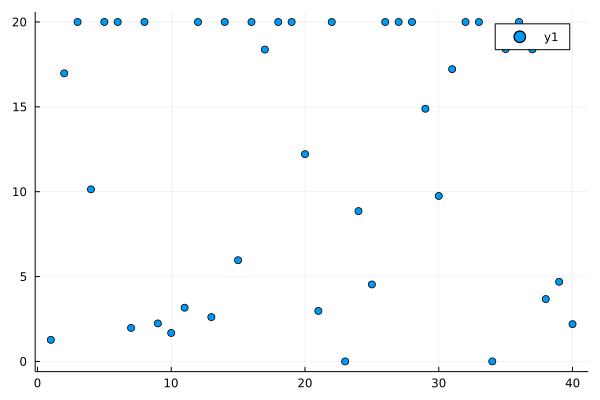

In [240]:
Mp = StochasticModel(Igen, T, θp, G, θpgen,V);
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);
xtrue = zeros(N)
sample!(xtrue)
println(sum(xtrue .< T) / N)
scatter(xtrue)

In [244]:
nobs, p = Int(round(N)), 1e-5 #p is mute
O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
f_rate = 1e-5
Ofalse=[rand()< f_rate ? (o[1],!o[2],o[3],f_rate) : (o[1],o[2],o[3],f_rate) for o in O]

40-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 1, 17.42700367565487, 1.0e-5)
 (2, 0, 11.65377510312966, 1.0e-5)
 (3, 0, 12.074470044685459, 1.0e-5)
 (4, 1, 19.4285609062758, 1.0e-5)
 (5, 0, 15.518797195679785, 1.0e-5)
 (6, 0, 15.399078395409314, 1.0e-5)
 (7, 1, 16.802727227658323, 1.0e-5)
 (8, 0, 12.13461068066875, 1.0e-5)
 (9, 1, 19.296301287678133, 1.0e-5)
 (10, 1, 18.666226188024382, 1.0e-5)
 (11, 1, 14.31184800719656, 1.0e-5)
 (12, 0, 14.155645597202325, 1.0e-5)
 (13, 1, 18.661055768983207, 1.0e-5)
 ⋮
 (29, 0, 11.296946935617742, 1.0e-5)
 (30, 1, 19.586444129058805, 1.0e-5)
 (31, 0, 10.527089303093618, 1.0e-5)
 (32, 0, 18.035841849984244, 1.0e-5)
 (33, 0, 14.731988544038517, 1.0e-5)
 (34, 1, 18.921212517953705, 1.0e-5)
 (35, 0, 10.831367710748989, 1.0e-5)
 (36, 0, 16.11660054822606, 1.0e-5)
 (37, 1, 19.875079821259906, 1.0e-5)
 (38, 1, 12.732208753184581, 1.0e-5)
 (39, 1, 13.325601347129819, 1.0e-5)
 (40, 1, 17.055302059617254, 1.0e-5)

In [245]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T);
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T );

θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen, V);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

## Causality 

In [246]:
θ = getpar(pseed, autoinf, inf_in);
M = StochasticModel(Igauss, T, θ, G, θp2gen, V);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [247]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, Ofalse; M=M, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
F = descend!(Mp2, Ofalse; M=M, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.03),
         hyperdescender=SignDescender(0.));

Progress:   6%|██▌                                      |  ETA: 0:00:05
  F:  16.85005596576465

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mreshape[22m
    [90m    @ [39m[90m./[39m[90m[4mreshapedarray.jl:51[24m[39m[90m [inlined][39m
      [2] [0m[1mreshape[22m
    [90m    @ [39m[90m./[39m[90m[4mreshapedarray.jl:111[24m[39m[90m [inlined][39m
      [3] [0m[1mreshape[22m
    [90m    @ [39m[90m./[39m[90m[4mreshapedarray.jl:141[24m[39m[90m [inlined][39m
      [4] [0m[1m_maybe_reshape_parent[22m
    [90m    @ [39m[90m./[39m[90m[4msubarray.jl:124[24m[39m[90m [inlined][39m
      [5] [0m[1mview[22m
    [90m    @ [39m[90m./[39m[90m[4msubarray.jl:178[24m[39m[90m [inlined][39m
      [6] [0m[1mmaybeview[22m
    [90m    @ [39m[90m./[39m[90m[4mviews.jl:146[24m[39m[90m [inlined][39m
      [7] [0m[1mindividual[22m[0m[1m([22m[90m#unused#[39m::[0mType[90m{GaussianInferentialSI}[39m, [90mθi[39m::[0mSubArray[90m{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[39m, [90mθg[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m~/git/Causality/src/[39m[90m[4msi.jl:20[24m[39m
      [8] [0m[1mindividual[22m[90m (repeats 3 times)[39m
    [90m    @ [39m[90m~/git/Causality/src/[39m[90m[4mstochasticmodel.jl:51[24m[39m[90m [inlined][39m
      [9] [0m[1m(::Causality.var"#5#6"{Matrix{Float64}, StochasticModel{GaussianInferentialSI, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}})[22m[0m[1m([22m[90mi[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m./[39m[90m[4mnone:0[24m[39m
     [10] [0m[1mMappingRF[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:95[24m[39m[90m [inlined][39m
     [11] [0m[1m_foldl_impl[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:62[24m[39m[90m [inlined][39m
     [12] [0m[1mfoldl_impl[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:48[24m[39m[90m [inlined][39m
     [13] [0m[1mmapfoldl_impl[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:44[24m[39m[90m [inlined][39m
     [14] [0m[1m#mapfoldl#244[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:162[24m[39m[90m [inlined][39m
     [15] [0m[1m#mapreduce#248[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:289[24m[39m[90m [inlined][39m
     [16] [0m[1m#sum#251[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:503[24m[39m[90m [inlined][39m
     [17] [0m[1m#sum#252[22m
    [90m    @ [39m[90m./[39m[90m[4mreduce.jl:532[24m[39m[90m [inlined][39m
     [18] [0m[1mlogQ[22m
    [90m    @ [39m[90m~/git/Causality/src/[39m[90m[4mvariation.jl:9[24m[39m[90m [inlined][39m
     [19] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m~/git/Causality/src/[39m[90m[4mvariation.jl:53[24m[39m[90m [inlined][39m
     [20] [0m[1m(::Causality.var"#12#threadsfor_fun#28"{StochasticModel{GaussianInferentialSI, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}, Int64, StochasticModel{GenerativeSI{GaussianRate, GaussianRate}, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}, Vector{Tuple{Int64, Bool, Float64, Float64}}, Matrix{Float64}, Vector{Causality.var"#sample!#43"{StochasticModel{GaussianInferentialSI, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}, TrackingHeaps.TrackingHeap{Int64, Float64, 2, TrackingHeaps.MinHeapOrder, TrackingHeaps.NoTrainingWheels}, BitVector, Int64}}, Vector{Float64}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Int64, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [21] [0m[1m(::Causality.var"#12#threadsfor_fun#28"{StochasticModel{GaussianInferentialSI, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}, Int64, StochasticModel{GenerativeSI{GaussianRate, GaussianRate}, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}, Vector{Tuple{Int64, Bool, Float64, Float64}}, Matrix{Float64}, Vector{Causality.var"#sample!#43"{StochasticModel{GaussianInferentialSI, IndexedGraphs.IndexedBiDiGraph{Int64}, Vector{UnitRate}}, TrackingHeaps.TrackingHeap{Int64, Float64, 2, TrackingHeaps.MinHeapOrder, TrackingHeaps.NoTrainingWheels}, BitVector, Int64}}, Vector{Float64}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Vector{Matrix{Float64}}, Int64, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mCausality[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [248]:
statscau = prior(M, numsamples=10000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## SoftMarg

In [249]:
stats,weights = softpostnoise(Mp, Ofalse; numsamples=2 * 10^5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


## Sib

In [250]:
using PyCall
@pyimport sib
function NonMarkovDynamicSibyl(N, T_cont, Λ, V, a, b, c, O, γ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    i = findnz(G.A)[1]
    j = findnz(G.A)[2]    
    contacts = [(i[a]-1, j[a]-1, t, 1.) for t in 1:T for a = 1:nnz(Λ.A) if (t * dt) in V[a].mask];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    g = sib.PiecewiseLinear(pycall(sib.RealParams, PyObject, [a*exp(-((t-b)/c)^2) * dt for t =1:T]))
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=1e-10,fp_rate=f_rate,fn_rate=f_rate, prob_i = g)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end

NonMarkovDynamicSibyl (generic function with 1 method)

In [251]:
a=time()
dt = 1
p_sib = NonMarkovDynamicSibyl(N, T, G, V, inf_out.a, inf_out.b, inf_out.c, Ofalse, 1/N; dt=dt, maxit = 4, tol = 1e-40);
b=time()
println(b-a)


sib.iterate(damp=0.0): 3/4 3.325e-01/1e-40      
sib.iterate(damp=0.5): 3/4 7.171e-02/1e-40      
0.5986950397491455.9): 3/4 9.474e-02/1e-40      


# Heuristic

In [123]:
using IntervalUnionArithmetic
T = Float64(T)
struct HeuristicSI <: SI end
maskauto = fill(intervalUnion(0., T),N)
maskinf = fill(intervalUnion(0., T),N)
θfrench = getpar(pseed, GaussianRate(1e-10,T,T), inf_in);
Causality.individual(M::StochasticModel{HeuristicSI}, i::Int, θi = @view(M.θ[:,i]), θg = M.θgen ) = 
@views IndividualSI(θi[1], 
    MaskedRate(GaussianRate(θi[2:4]...),maskauto[i]), 
    MaskedRate(UnitRate(),maskinf[i]), 
    GaussianRate(θg[5:7]...),)


for o in Ofalse
    if o[2] == 1 
        maskauto[o[1]] = maskauto[o[1]] ∩ intervalUnion(o[3]-5, T)        
        θfrench[2,o[1]] = 10
        θfrench[3,o[1]] = o[3] - 5
        θfrench[4,o[1]] = 10
    elseif o[2] == 0
        maskinf[o[1]] = maskinf[o[1]] ∩ intervalUnion(o[3], T)
        θfrench[1,o[1]] = 1e-10
    end
end

Mfrench = StochasticModel(HeuristicSI, T, θfrench, G, θp2gen);
statsfre = prior(Mfrench,numsamples=10000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


## Metropolis Monte Carlo

In [124]:
K = Causality.GaussMove(2.)
#stats_mh = Causality.metropolis_sampling_parallel(Mp, O, K; numsamples = 10^3,numsteps=10^3)
xmc = zeros(N)
sample!(xmc)
Mmc = StochasticModel(Igen, T, θp, G, θpgen,V);
stats_mh = Causality.metropolis_sampling_sequential(Mp, Ofalse, K; numsamples = 10,numsteps= 1000, x = xmc);

## Marginals and ROC curve

In [142]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function reweighted_marginal(i, t, stats, weights)
    numsamp = size(stats,1)
    @assert numsamp == size(weights,1)
    weights ./= maximum(weights)
    sum(weights .* (stats[:,i] .< t))/sum(weights)
end


function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [143]:
#Marginals
bins = 1 * Int(T)
using Plots
p_cau = zeros(N,bins)
p_french = zeros(N,bins)
p_mh = zeros(N,bins)
p_soft = zeros(N,bins)
for i = 1:N
    for t = 1:bins
       p_cau[i,t] = marginal(i, t*T/bins, statscau)
       p_french[i,t] = marginal(i, t*T/bins, statsfre)
       p_mh[i,t] = marginal(i, t*T/bins, stats_mh)
       p_soft[i,t] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
end

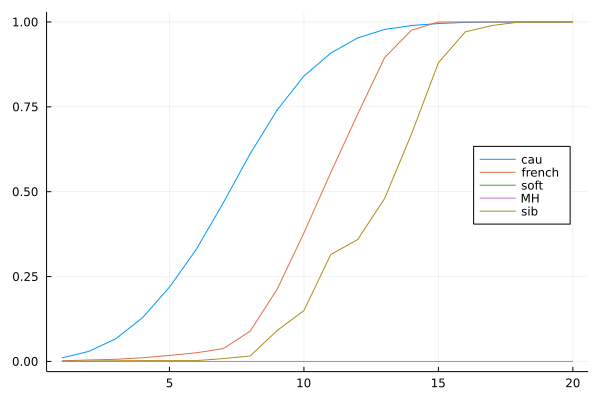

In [144]:
i = 88
plot(LinRange(1,Int(T),bins),p_cau[i,:], label = "cau", legend=:right)
plot!(LinRange(1,Int(T),bins),p_french[i,:], label = "french")
plot!(LinRange(1,Int(T),bins),p_soft[i,:], label = "soft")
plot!(LinRange(1,Int(T),bins),p_mh[i,:], label = "MH")
plot!(LinRange(1,Int(T),Int(round(T/dt))),p_sib[i,:], label = "sib")

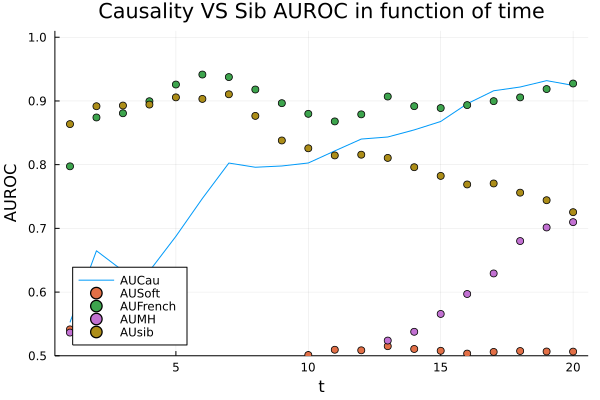

In [145]:
#AUROC curves

T = Int(T)
AU_curve=zeros(T)
AU_sib=zeros(T)
AU_french = zeros(T)
AU_soft = zeros(T)
AU_MH = zeros(T)
for t = 1:T
    cau_risk=zeros(N)
    sib_risk = zeros(N)
    french_risk = zeros(N)
    MH_risk = zeros(N)
    soft_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t,statscau)
       french_risk[i] = marginal(i,t,statsfre)
       MH_risk[i] = marginal(i,min(t,(T - 1)),stats_mh)
       sib_risk[i] = p_sib[i,Int(round(t/dt))]
       soft_risk[i] = reweighted_marginal(i, t, stats, weights)
    end
    xt = xtrue .< t
    AU_soft[t] = AUROC(ROC(xt, soft_risk))
    AU_curve[t] = AUROC(ROC(xt, cau_risk))
    AU_french[t] = AUROC(ROC(xt, french_risk))
    AU_MH[t] = AUROC(ROC(xt, MH_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
end

plot(LinRange(1,T,T),AU_curve, label="AUCau", title="Causality VS Sib AUROC in function of time")
scatter!(LinRange(1,T,T),AU_soft, label="AUSoft",legend=:bottomleft)
scatter!(LinRange(1,T,T),AU_french, label="AUFrench")
scatter!(LinRange(1,T,T),AU_MH, label="AUMH")
scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
xlabel!("t")
ylabel!("AUROC")
#savefig("confronti.pdf")
ylims!(0.5,1.01)